In [1]:
# Install dependencies
!pip install matplotlib
!pip install numpy
!pip install pettingzoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 852.5/852.5 kB 49.4 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import time
from matplotlib import pyplot as plt
import random
from prioritized_memory import Memory
from env import ContinuousWorldParallelEnv
import os
from model_def import Net

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the base directory in Google Drive
base_dir = '/content/drive/MyDrive/dqn_training_after_tuning_reward'
os.makedirs(base_dir, exist_ok=True)


Mounted at /content/drive


Obstacle image 'sprites/obs1_2.png' not found, using colored rectangle
Obstacle image 'sprites/obs3.png' not found, using colored rectangle
Obstacle image 'sprites/obs1_2.png' not found, using colored rectangle
State dimension: 11
Action dimension: 2
Number of agents: 2
Using device: cuda


/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Starting training...
Saved model and data at episode 100
Saved model and data at episode 200
Saved model and data at episode 300
Saved model and data at episode 400
Saved model and data at episode 500
Saved model and data at episode 600
Saved model and data at episode 700
Episode: 790, Return: -246.89, Success Rate: 1.000, Epsilon: 0.802
Episode: 800, Return: -221.98, Success Rate: 0.944, Epsilon: 0.800


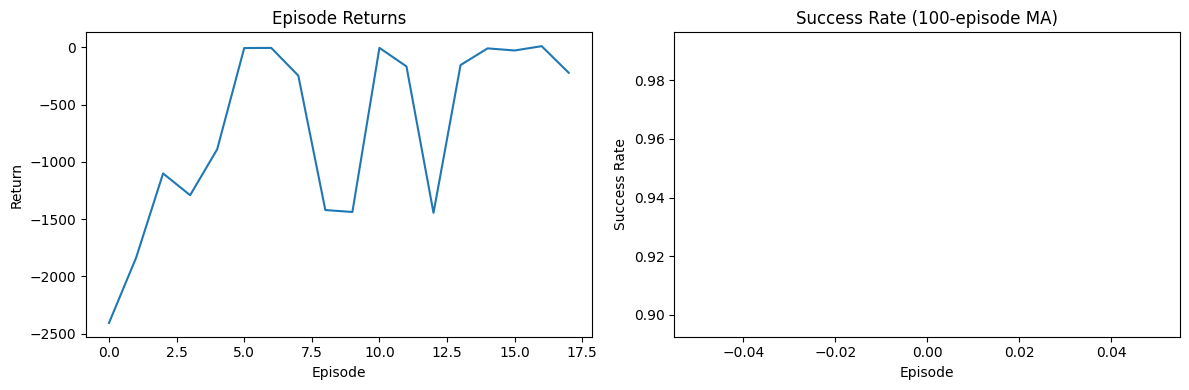

Saved model and data at episode 800
Episode: 810, Return: -3.74, Success Rate: 0.964, Epsilon: 0.797
Episode: 820, Return: -96.58, Success Rate: 0.947, Epsilon: 0.795
Episode: 830, Return: -1035.82, Success Rate: 0.938, Epsilon: 0.792
Episode: 840, Return: -2109.41, Success Rate: 0.931, Epsilon: 0.790
Episode: 850, Return: -43.62, Success Rate: 0.926, Epsilon: 0.787


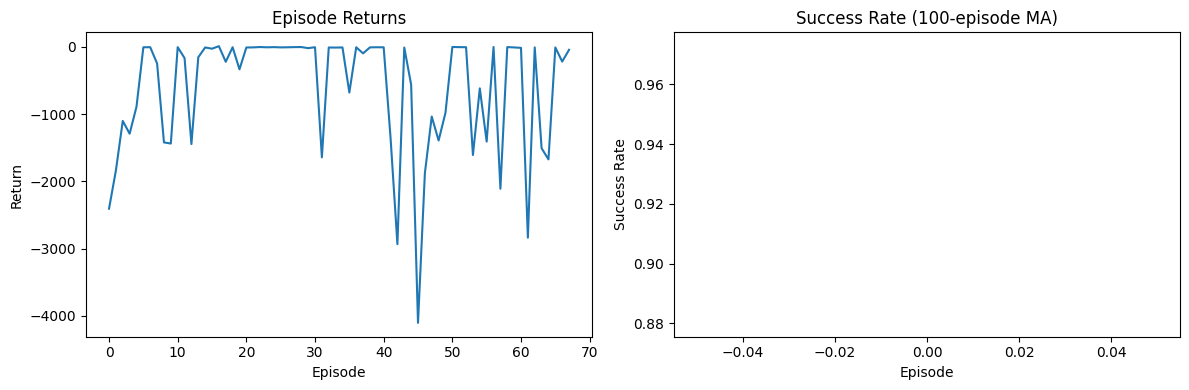

Episode: 860, Return: -2280.58, Success Rate: 0.910, Epsilon: 0.785
Episode: 870, Return: -8.48, Success Rate: 0.920, Epsilon: 0.782
Episode: 880, Return: -7.25, Success Rate: 0.918, Epsilon: 0.780
Episode: 890, Return: -143.02, Success Rate: 0.920, Epsilon: 0.777
Episode: 900, Return: 1.45, Success Rate: 0.930, Epsilon: 0.775


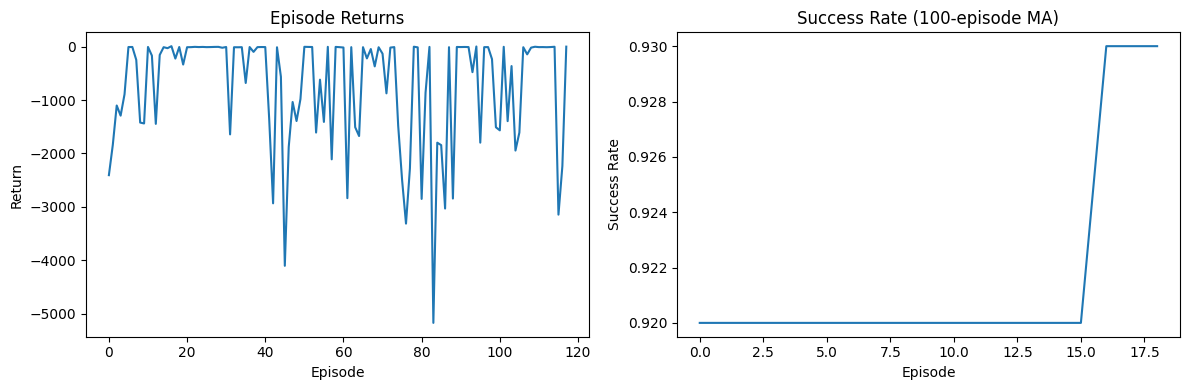

Saved model and data at episode 900
Episode: 910, Return: -1653.70, Success Rate: 0.930, Epsilon: 0.772
Episode: 920, Return: -7.10, Success Rate: 0.940, Epsilon: 0.770
Episode: 930, Return: -1453.69, Success Rate: 0.950, Epsilon: 0.767
Episode: 940, Return: -9.22, Success Rate: 0.960, Epsilon: 0.765
Episode: 950, Return: -6.95, Success Rate: 0.970, Epsilon: 0.762


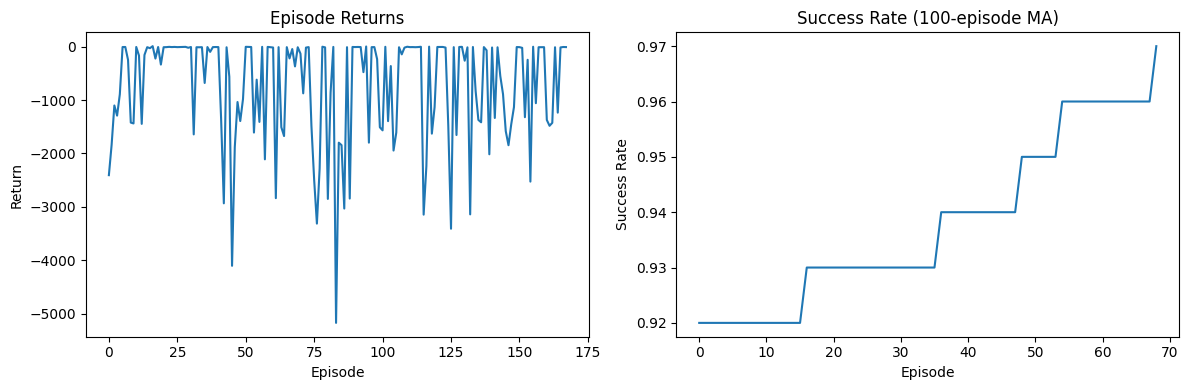

Episode: 960, Return: -2.80, Success Rate: 0.990, Epsilon: 0.760
Episode: 970, Return: -6.28, Success Rate: 0.990, Epsilon: 0.758
Episode: 980, Return: -995.66, Success Rate: 0.980, Epsilon: 0.755
Episode: 990, Return: -20.75, Success Rate: 0.980, Epsilon: 0.752
Training completed!


In [5]:
# Hyper Parameters
episode_max = 1000
batch_size = 128
lr = 3e-4
epsilon_origin = 1.0
epsilon_decrement = 1 / 4000
gamma = 0.99
target_replace_iter = 200
memory_size = int(1e6)

# Environment setup
env = ContinuousWorldParallelEnv(
    n_agents=2,
    max_cycles=1000,
    world_size=(10, 10),
    render_mode=None,  # No rendering for training
    dc=0.5,
    ds=2.0,
    evader_speed=400,
    scale=100,
    pursuer_speed=300
)

# Get environment dimensions
obs, _ = env.reset()
sample_obs = obs[env.agents[0]]
num_state = len(sample_obs)
num_action = 2  # APF parameters: [eta_scale, individual_balance]
num_agent = env.n_agents

print(f"State dimension: {num_state}")
print(f"Action dimension: {num_action}")
print(f"Number of agents: {num_agent}")

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(num_state), Net(num_state) # use the imported Net class
        self.learn_step_counter = 0
        self.memory = Memory(memory_size, num_state)
        self.optimizer = torch.optim.Adam(self.eval_net.parameters(), lr=lr)
        self.loss_func = nn.MSELoss(reduction='none')
        self.max_td_error = 0.

    def choose_action(self, state, epsilon):
        state = torch.tensor(state, dtype=torch.float32, device=device).view(1, -1)

        if np.random.uniform() > epsilon:
            eta_q, balance_q = self.eval_net(state)
            eta_action = torch.max(eta_q, 1)[1].to('cpu').data.numpy().item()
            balance_action = torch.max(balance_q, 1)[1].to('cpu').data.numpy().item()
        else:
            eta_action = np.random.randint(0, 10)
            balance_action = np.random.randint(0, 10)

        # Convert discrete actions to continuous APF parameters
        eta_scale = self.eval_net.eta_options[eta_action]
        individual_balance = self.eval_net.balance_options[balance_action]

        return np.array([eta_scale, individual_balance], dtype=np.float32), (eta_action, balance_action)

    def store_transition(self, state, action_indices, reward, state_next, done):
        # Store the discrete action indices for learning
        transition = np.hstack((
            np.ravel(state),
            np.ravel(action_indices),
            np.ravel(reward),
            np.ravel(state_next),
            np.ravel(done)
        ))
        self.memory.add(self.max_td_error, transition)

    def learn(self, i_episode):
        if self.learn_step_counter % target_replace_iter == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        b_memory, indexs, omega = self.memory.sample(batch_size, i_episode, episode_max)
        b_state = torch.tensor(b_memory[:, :num_state], dtype=torch.float32, device=device)
        b_eta_action = torch.tensor(b_memory[:, num_state:num_state + 1], dtype=torch.int64, device=device)
        b_balance_action = torch.tensor(b_memory[:, num_state + 1:num_state + 2], dtype=torch.int64, device=device)
        b_reward = torch.tensor(b_memory[:, num_state + 2:num_state + 3], dtype=torch.float32, device=device)
        b_state_next = torch.tensor(b_memory[:, num_state + 3:num_state * 2 + 3], dtype=torch.float32, device=device)
        b_done = torch.tensor(b_memory[:, num_state * 2 + 3:num_state * 2 + 4], dtype=torch.float32, device=device)

        # Current Q values
        eta_q_eval, balance_q_eval = self.eval_net(b_state)
        eta_q_current = eta_q_eval.gather(1, b_eta_action)
        balance_q_current = balance_q_eval.gather(1, b_balance_action)

        # Target Q values (Double DQN)
        eta_q_next_target, balance_q_next_target = self.target_net(b_state_next)
        eta_q_next_eval, balance_q_next_eval = self.eval_net(b_state_next)

        eta_next_actions = torch.argmax(eta_q_next_eval, axis=1, keepdim=True)
        balance_next_actions = torch.argmax(balance_q_next_eval, axis=1, keepdim=True)

        eta_q_target = b_reward + gamma * (1 - b_done) * eta_q_next_target.gather(1, eta_next_actions)
        balance_q_target = b_reward + gamma * (1 - b_done) * balance_q_next_target.gather(1, balance_next_actions)

        # Calculate TD errors
        eta_td_errors = (eta_q_target - eta_q_current).to('cpu').detach().numpy()
        balance_td_errors = (balance_q_target - balance_q_current).to('cpu').detach().numpy()

        # Combined TD error for priority update
        combined_td_errors = (eta_td_errors + balance_td_errors) / 2
        self.max_td_error = max(np.max(np.abs(combined_td_errors)), self.max_td_error)

        for i in range(batch_size):
            index = indexs[i, 0]
            td_error = combined_td_errors[i, 0]
            self.memory.update(index, td_error)

        # Combined loss
        eta_loss = self.loss_func(eta_q_current, eta_q_target.detach())
        balance_loss = self.loss_func(balance_q_current, balance_q_target.detach())

        omega_tensor = torch.FloatTensor(omega).to(device).detach()
        loss = ((eta_loss + balance_loss) * omega_tensor).mean()

        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping
        for param in self.eval_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

class RunningStat:
    def __init__(self, shape):
        self.n = 0
        self.mean = np.zeros(shape)
        self.s = np.zeros(shape)
        self.std = np.zeros(shape)

    def push(self, x):
        self.n += 1
        if self.n == 1:
            self.mean = x
        else:
            old_mean = self.mean.copy()
            self.mean = old_mean + (x - old_mean) / self.n
            self.s = self.s + (x - old_mean) * (x - self.mean)
            self.std = np.sqrt(self.s / (self.n - 1) if self.n > 1 else np.square(self.mean))

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

dqn = DQN()
running_stats = [RunningStat((1,)) for _ in range(num_agent)]
dqn.eval_net.to(device)
dqn.target_net.to(device)

i_episode = 0
episode_return_total = np.zeros(0)
success_rate_history = []

print("Starting training...")

while i_episode < episode_max:
    obs, _ = env.reset()
    episode_return = 0
    episode_success = False
    step_count = 0

    # Convert obs to list format for easier handling
    states = [obs[agent_name] for agent_name in env.agents]

    while step_count < env.max_cycles:
        # Choose actions for all agents
        actions = {}
        action_indices = []

        current_epsilon = max(epsilon_origin - epsilon_decrement * i_episode, 0.01)

        for i, agent_name in enumerate(env.agents):
            if not env.agents_objects[i].reached_evader:
                action, indices = dqn.choose_action(states[i], current_epsilon)
                actions[agent_name] = action
                action_indices.append(indices)
            else:
                # Default action for terminated agents
                actions[agent_name] = np.array([2.0, 2000.0], dtype=np.float32)
                action_indices.append((1, 5))  # Default indices

        # Step environment
        obs_next, rewards, terminated, truncated, infos = env.step(actions)
        states_next = [obs_next[agent_name] for agent_name in env.agents]

        # Store transitions and calculate episode return
        for i, agent_name in enumerate(env.agents):
            if not env.agents_objects[i].reached_evader:
                reward = rewards[agent_name]
                done = terminated[agent_name] or truncated[agent_name]

                episode_return += reward
                running_stats[i].push(np.array([reward]))

                # Normalize reward
                normalized_reward = np.clip(
                    reward / (running_stats[i].std[0] + 1e-8), -10, 10
                )

                # Store transition
                dqn.store_transition(
                    states[i],
                    action_indices[i],
                    normalized_reward,
                    states_next[i],
                    1.0 if done else 0.0
                )

        # Check for episode termination
        if all(terminated.values()) or all(truncated.values()):
            episode_success = any(agent.reached_evader for agent in env.agents_objects)
            break

        states = states_next
        step_count += 1

    # Learning phase
    if dqn.memory.tree.n_entries >= memory_size:
        for _ in range(500):  # Multiple learning steps per episode
            dqn.learn(i_episode)

    # Logging and visualization
    if dqn.memory.tree.n_entries < memory_size:
        print(f"Collecting experiences: {dqn.memory.tree.n_entries} / {memory_size}")
    else:
        episode_return_total = np.append(episode_return_total, episode_return)
        success_rate_history.append(1.0 if episode_success else 0.0)

        if i_episode % 10 == 0:
            recent_success_rate = np.mean(success_rate_history[-100:]) if len(success_rate_history) >= 100 else np.mean(success_rate_history)
            print(f'Episode: {i_episode}, Return: {episode_return:.2f}, Success Rate: {recent_success_rate:.3f}, Epsilon: {current_epsilon:.3f}')

        # Plot progress
        if i_episode % 50 == 0:
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 2, 1)
            plt.plot(episode_return_total)
            plt.title('Episode Returns')
            plt.xlabel('Episode')
            plt.ylabel('Return')

            plt.subplot(1, 2, 2)
            if len(success_rate_history) > 0:
                # Moving average of success rate
                window_size = min(100, len(success_rate_history))
                success_ma = np.convolve(success_rate_history, np.ones(window_size)/window_size, mode='valid')
                plt.plot(success_ma)
                plt.title('Success Rate (100-episode MA)')
                plt.xlabel('Episode')
                plt.ylabel('Success Rate')

            plt.tight_layout()
            plot_path = os.path.join(base_dir, f'training_progress_{i_episode}.png')  # Corrected line
            plt.savefig(plot_path)
            plt.show() # Changed from plt.show(block=False) and removed plt.pause
            plt.close()

    # Save model and data
    if i_episode % 100 == 0 and i_episode > 0:
        model_path = os.path.join(base_dir, f'dqn_model_{i_episode}.pt')
        torch.save(dqn.eval_net.state_dict(), model_path)

        data_path = os.path.join(base_dir, f'episode_returns_{i_episode}.txt')
        np.savetxt(data_path, episode_return_total)

        success_path = os.path.join(base_dir, f'success_rates_{i_episode}.txt')
        np.savetxt(success_path, success_rate_history)

        print(f"Saved model and data at episode {i_episode}")

    i_episode += 1

print("Training completed!")
env.close()

# Final save
final_model_path = os.path.join(base_dir, 'dqn_final.pt')
torch.save(dqn.eval_net.state_dict(), final_model_path)

final_returns_path = os.path.join(base_dir, 'final_episode_returns.txt')
np.savetxt(final_returns_path, episode_return_total)

final_success_path = os.path.join(base_dir, 'final_success_rates.txt')
np.savetxt(final_success_path, success_rate_history)